<a href="https://colab.research.google.com/github/HyeongseokKim/My_codes/blob/main/07_01_Auto_Encoder%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

2.0.1+cu118


# AUTO ENCODER

### 1-1. Simple AUTO ENCODER

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
from tqdm.auto import tqdm #진행률 확인

오토인코더는 비지도학습이므로 y의 값을 받지않고 진행합니다.

데이터를 정규화 하여 학습에 알맞은 형태로 바꿉니다.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # 정규화 ? -> 원본을 그대로 만들어 내는 것이므로 정규화를 진행하지 않아도 무방
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

Hidden_input은 아래 그림에서 중간 노란색 노드의 개수를 의미합니다.   
즉, Encoding 단계에서 이미지를 얼마만큼 압축할 것인지를 의미합니다.  

In [9]:
hidden_dim = 100 # 압축 크기

오토인코더의 구조는 간단합니다.  
입력층 --> 히든층 --> 출력층 으로 이루어져 있습니다.  

선언하는 Model은 원래는 한개지만 압축 후에는 어떤 형태를 이루는지 보기위해서 인코더 모델을 하나 더 만들어보겠습니다.

In [10]:
# 오토인코더
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()

        self.encoder = nn.Sequential( # 입력, 히든층
            nn.Linear(28*28, hidden_dim) # 인코더에서는 이미지를 압축합니다.
        )

        self.decoder = nn.Sequential( # 출력층
            nn.Linear(hidden_dim, 28*28), # 디코더에서는 원래크기로 복원합니다.
            nn.Sigmoid(),  # 픽셀당 0과 1사이의 값으로 출력하는 sigmoid 활성화 함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [14]:
model = SimpleAutoEncoder()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

#criterion = nn.CrossEntropyLoss().cuda() # sigmoid를 사용했으니 Binary_crossentropy를 사용합니다.
criterion = nn.BCELoss().cuda() #평균제곱오차인 MSELoss도 사용이 가능합니다 !
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [15]:
# 모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, _) in enumerate(tqdm(iter(train_loader))):
        # 해당 코드가 이미지를 압축했다가 재구성을 하므로 입력과 출력은 data를 넣고 진행합니다.
        # x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        x = data.view(-1, 28*28).to(device)
        y = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()

        # decoded와 원본이미지(y) 사이의 오차를 구합니다
        encoded, decoded = model(x)
        loss = criterion(decoded, y)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, _ in tqdm(iter(test_loader)):
            x = data.view(-1, 28*28).to(device)
            y = data.view(-1, 28*28).to(device)
            encoded, decoded = model(x)
            loss = criterion(decoded, y)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.09683] Val Loss : [0.07090]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.06981] Val Loss : [0.06844]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.06838] Val Loss : [0.06772]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06784] Val Loss : [0.06737]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.06754] Val Loss : [0.06718]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.06733] Val Loss : [0.06695]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.06718] Val Loss : [0.06683]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.06708] Val Loss : [0.06675]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.06700] Val Loss : [0.06672]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.06695] Val Loss : [0.06668]


이번에는 학습이 잘 되었는지를 확인하기 위해 Predict를 하겠습니다.  
encoder에 test_data를 넣어 압축된 이미지를 생성합니다.  

In [16]:
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28*28).to(device)
        encoded, decoded = model(data)
        break

In [18]:
encoded.shape

torch.Size([64, 100])

In [19]:
decoded.shape

torch.Size([64, 784])

원래 이미지를 50개 정도 출력을 해보겠습니다.

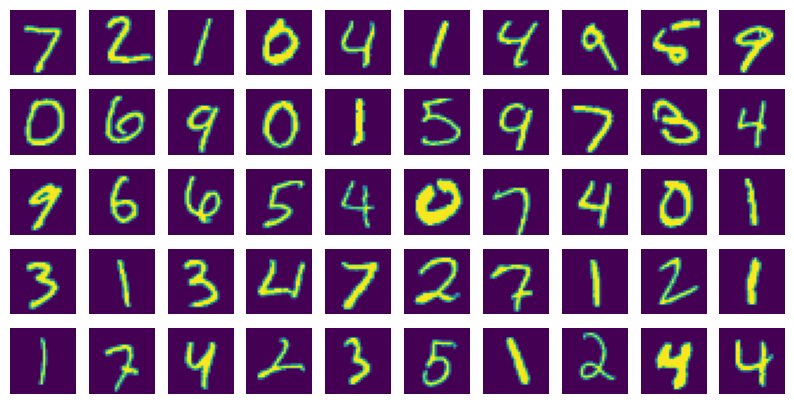

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(data[i].reshape(28,28))
        plt.axis('off')
    break

plt.show()

이번에는 압축시킨 이미지를 출력시켜보겠습니다.  

In [20]:
encoded[0].shape

torch.Size([100])

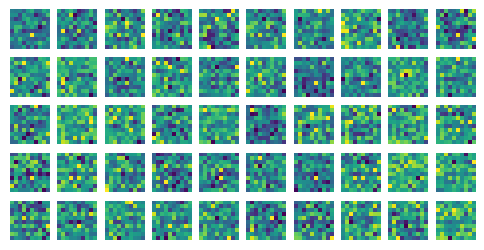

In [21]:
plt.figure(figsize=(6,3))
for i in range(50) :
  plt.subplot(5,10,i+1)
  plt.imshow(encoded[i].cpu().reshape(10,10))
  plt.axis('off')
plt.show()

모델에서 압축된 이미지(encoded)와 예측한 이미지(decoded)까지 모두 반환하기 때문에, 예측한 이미지를 이미 가지고 있습니다.

In [22]:
decoded[3].shape

torch.Size([784])

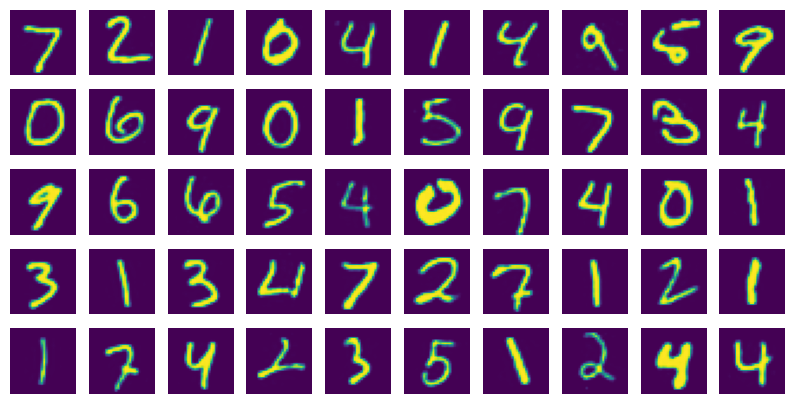

In [23]:
plt.figure(figsize=(10,5))
for i in range(50) :
  plt.subplot(5,10,i+1)
  plt.imshow(decoded[i].cpu().reshape(28,28))
  plt.axis('off')
plt.show()

원래 데이터와 압축후에 나온 데이터를 비교했을 때 흐릿한 것을 알 수가 있습니다.  

### 1-2 Deep AUTO ENCODER 실습

이번에는 싱글로 구성된 오토인코더 아닌 여러층으로 깊이 쌓은 오토인코더를 만들어보겠습니다.   
(train_loader, test_loader 부분까지는 위에 코드를 그대로 사용하므로, 생략하겠습니다.)

이번에는 여러층을 쌓기 위해서 hidden_input을 다양하게 설정하겠습니다.

In [46]:
# 오토인코더 모델 구성
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512), # 인코더 부분에서는 차원을 점차 줄여나가겠습니다.
            nn.Linear(512, 128),
            nn.Linear(128, 32),
            nn.Linear(32, 8),
            nn.Linear(8, 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 32), # 디코더 부분에서는 차원을 점차 28*28로 복원합니다.
            nn.Linear(32, 128),
            nn.Linear(128, 512),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [47]:
model = SimpleAutoEncoder()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [48]:
# 모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, _) in enumerate(tqdm(iter(train_loader))):
        # 해당 코드가 이미지를 압축했다가 재구성을 하므로 입력과 출력은 data를 넣고 진행합니다.
        # x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        x = data.view(-1, 28*28).to(device)
        y = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()

        # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        encoded, decoded = model(x)
        loss = criterion(decoded, y)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, _ in tqdm(iter(test_loader)):
            x = data.view(-1, 28*28).to(device)
            y = data.view(-1, 28*28).to(device)
            encoded, decoded = model(x)
            loss = criterion(decoded, y)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.05754] Val Loss : [0.05549]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.05551] Val Loss : [0.05507]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.05539] Val Loss : [0.05504]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.05532] Val Loss : [0.05507]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.05529] Val Loss : [0.05492]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.05525] Val Loss : [0.05490]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.05523] Val Loss : [0.05489]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.05521] Val Loss : [0.05489]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.05519] Val Loss : [0.05486]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05519] Val Loss : [0.05487]


In [49]:
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28*28).to(device)
        encoded, decoded = model(data)
        break

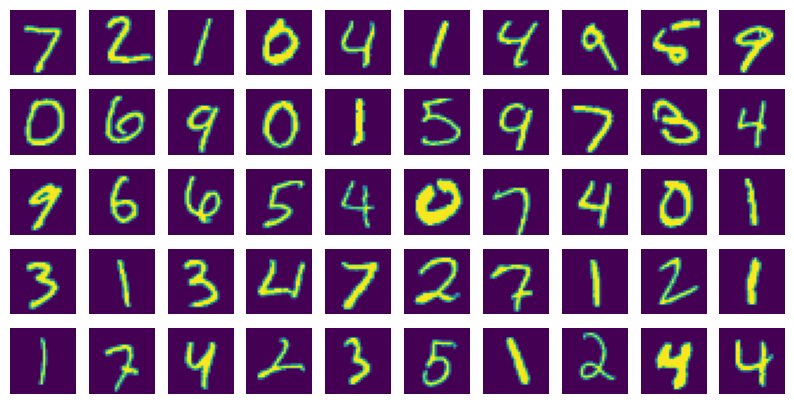

In [50]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(data[i].reshape(28,28))
        plt.axis('off')
    break

plt.show()

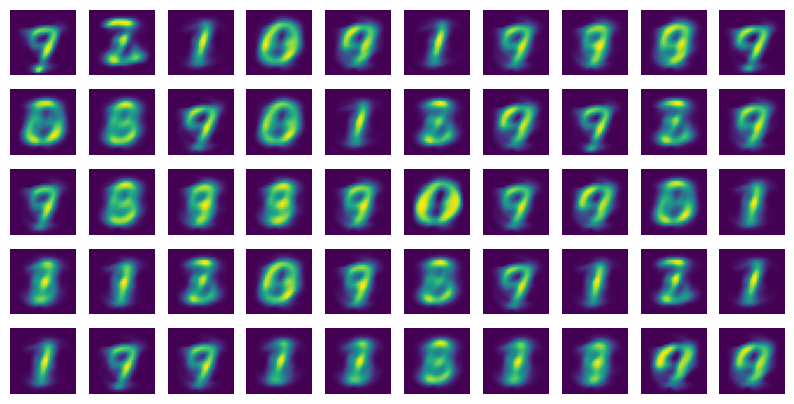

In [51]:
plt.figure(figsize=(10,5))
for i in range(50) :
  plt.subplot(5,10,i+1)
  plt.imshow(decoded[i].cpu().reshape(28,28))
  plt.axis('off')

plt.show()

### 1-3 Convolutional AUTO ENCODER 실습

활성함수를 relu로 설정하였고, 필터사이즈가 영향을 가지 않게 padding을 설정하였습니다.  

In [63]:
# 컨볼루션 오토인코더 모델 구성
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        # 활성함수를 relu로 설정하였고, 필터사이즈가 영향을 가지 않게 padding을 설정하였습니다.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


모델을 확인 했을 때 이미지가 원래 크기로 돌아온 것을 확인할 수 있습니다.

In [53]:
%pip install torchsummary

In [64]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CNNAutoEncoder()
model.to(device)

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 16, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (5): Sigmoid()
  )
)

In [65]:
import torchsummary
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]             320
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3           [-1, 32, 10, 10]           8,224
         LeakyReLU-4           [-1, 32, 10, 10]               0
            Conv2d-5             [-1, 16, 7, 7]           2,064
         LeakyReLU-6             [-1, 16, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 10, 10]           2,080
         LeakyReLU-8           [-1, 32, 10, 10]               0
   ConvTranspose2d-9           [-1, 64, 16, 16]           8,256
        LeakyReLU-10           [-1, 64, 16, 16]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]             257
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 21,201
Trainable params: 21,201
Non-trainable params: 0
---------------------------------

In [66]:
criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [67]:
# 모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, _) in enumerate(tqdm(iter(train_loader))):
        # 입력이 3차원 벡터이기 때문에, 따로 reshape을 하지 않습니다.
        x = data.to(device)
        y = data.to(device)

        optimizer.zero_grad()

        encoded, decoded = model(x)
        loss = criterion(decoded, y)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, _ in tqdm(iter(test_loader)):
            x = data.to(device)
            y = data.to(device)
            encoded, decoded = model(x)
            loss = criterion(decoded, y)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.08818] Val Loss : [0.06842]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.06784] Val Loss : [0.06673]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.06681] Val Loss : [0.06607]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06632] Val Loss : [0.06567]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.06603] Val Loss : [0.06549]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.06583] Val Loss : [0.06529]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.06569] Val Loss : [0.06518]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.06560] Val Loss : [0.06510]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.06553] Val Loss : [0.06504]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.06547] Val Loss : [0.06500]


예측을 하여 원래 데이터셋과 비교를 해보겠습니다.

In [68]:
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        encoded, decoded = model(data)
        break

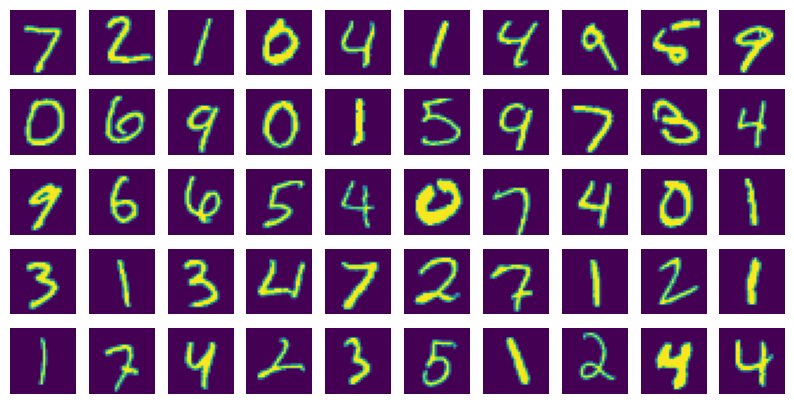

In [69]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(data[i].permute(1, 2, 0))
        plt.axis('off')
    break

plt.show()

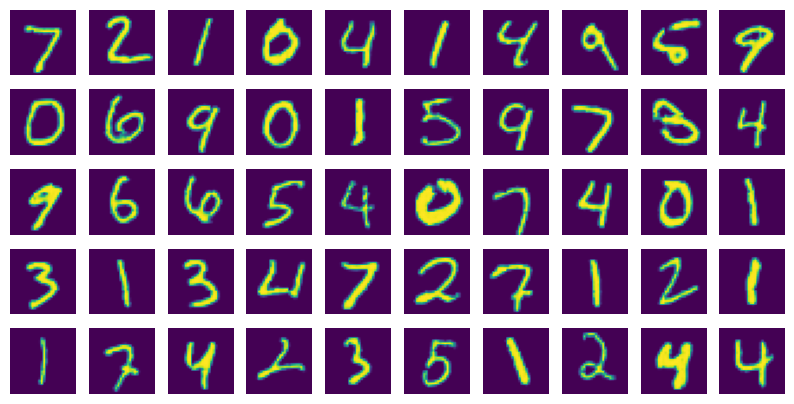

In [70]:
plt.figure(figsize=(10,5))
for i in range(50) :
  plt.subplot(5,10,i+1)
  plt.imshow(decoded[i].cpu().permute(1, 2, 0))
  plt.axis('off')

plt.show()

CNN 모델을 사용한 AUTO ENCODER를 확인 했을 때 노이즈가 별로 없으며 원래 이미지와 별 차이가 없는 모습을 보입니다.

### 1-4 Denoising AUTO ENCODER

노이즈가 있는 이미지를 AUTO ENCODER를 이용하여 원복 시키겠습니다.  
이번에는 Convolution AUTO ENCODER 코드를 가져와서 사용해보겠습니다.

먼저, 노이즈가 적용되기 전 데이터셋을 살펴 보겠습니다.

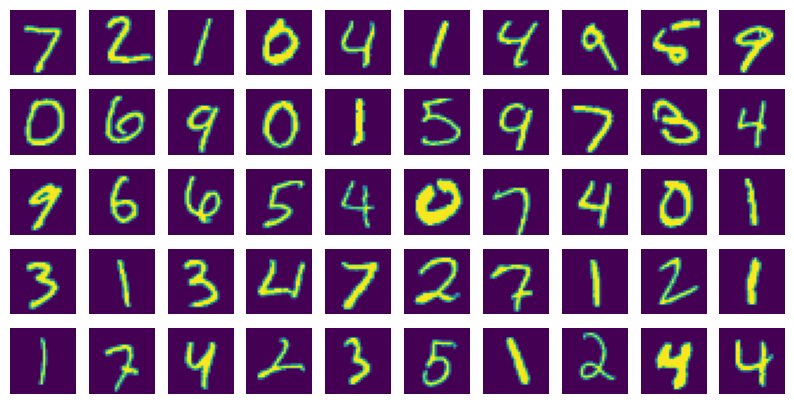

In [71]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(data[i].permute(1, 2, 0))
        plt.axis('off')
    break

plt.show()

여기에 강제로 노이즈를 추가해보겠습니다.

In [74]:
np.random.normal(0.0, 1.0, (28, 28))

array([[-1.33220587e-01, -9.64167976e-01,  2.36766131e+00,
        -7.09610151e-01,  1.00602488e+00, -4.99663811e-01,
         3.73550051e-01, -3.05695332e-01,  9.03883735e-01,
         1.02843302e+00, -7.72202087e-01,  4.58524312e-01,
         9.20113145e-01, -2.89250654e-01,  2.49125198e-01,
         3.14422587e-01,  6.03095010e-01,  1.75170911e+00,
         1.69595305e-01,  1.70363517e+00, -8.04191568e-01,
        -9.65604383e-01, -1.47592430e+00, -2.90170786e-02,
        -9.03055351e-01, -4.95168386e-01,  1.32456329e-01,
        -1.89664727e+00],
       [-2.36357425e-01, -1.71679890e+00, -8.27528926e-01,
        -5.35538410e-01, -9.83480828e-01,  1.86719053e+00,
        -6.17152021e-01,  1.32121313e+00,  1.14543261e+00,
         5.35675326e-01,  1.38886492e-01, -2.08749747e+00,
         7.02337935e-03, -6.68996381e-01, -4.54459761e-01,
         9.18886908e-01,  6.83335283e-01, -2.77769702e-01,
         9.80716206e-01,  6.88770082e-02, -1.80235394e+00,
         4.26425030e-04, -1.02

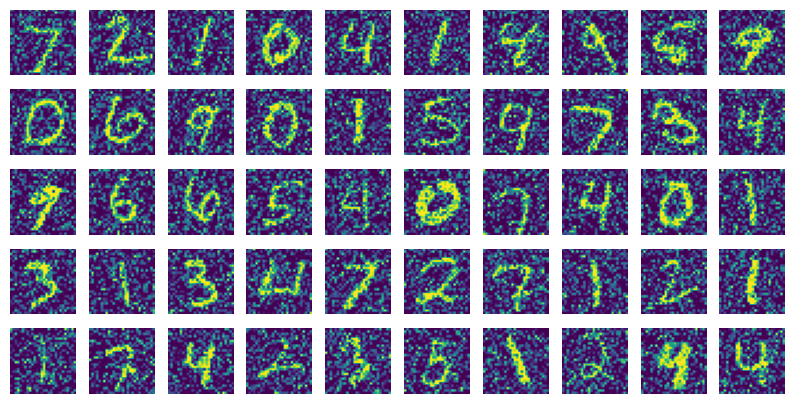

In [75]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)

        image_noise = np.random.normal(0.0, 1.0, data[i].shape)
        noise_data = np.clip(data[i]+image_noise*0.4, 0., 1.)

        plt.imshow(noise_data.permute(1, 2, 0))
        plt.axis('off')
    break

plt.show()

노이즈가 적용되서 원래의 이미지보다 알아보기가 힘든 점을 볼수 가 있습니다.  
아까 1-1-3 실습을 할 때 만들었던 코드를 수정없이 진행을 해보겠습니다.

In [76]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CNNAutoEncoder()
model.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

이번에는 결과값에다가는 노이즈가 적용이 안된 데이터셋을 넣어줍니다.  
그래야 노이즈를 제거하고 데이터를 원복 시킬 수 있습니다.  

In [79]:
#모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10

for epoch in range(1, epochs+1):
    #학습
    model.train()
    train_loss = []
    for batch_idx, (data, _) in enumerate(tqdm(iter(train_loader))):
        #입력 이미지에 임의로 noise를 추가합니다.
        image_noise = torch.rand(data.shape)
        x = torch.clip(data+image_noise*0.4, 0., 1.).to(device)
        y = data.to(device)

        optimizer.zero_grad()

        encoded, decoded = model(x)
        loss = criterion(decoded, y)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    #테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, _ in tqdm(iter(test_loader)):
            x = data.to(device)
            y = data.to(device)
            encoded, decoded = model(x)
            loss = criterion(decoded, y)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.07143] Val Loss : [0.08751]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.07108] Val Loss : [0.08735]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.07083] Val Loss : [0.08563]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.07066] Val Loss : [0.08733]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.07054] Val Loss : [0.08772]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.07045] Val Loss : [0.08816]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.07039] Val Loss : [0.08898]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.07034] Val Loss : [0.08943]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.07032] Val Loss : [0.08873]


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.07029] Val Loss : [0.08883]


노이즈 테스트 데이터 셋을 넣어 예측이 잘되는지 살펴보겠습니다.  

In [80]:
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        image_noise = torch.rand(data.shape)
        noise_test_data = torch.clip(data+image_noise*0.4, 0., 1.).to(device)
        encoded, decoded = model(noise_test_data)
        break

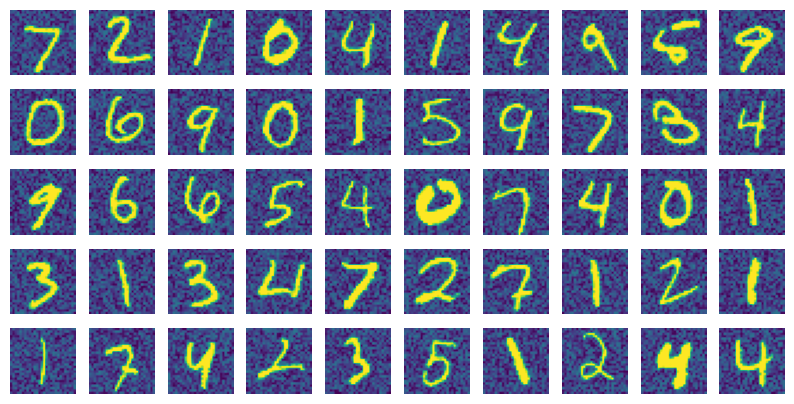

In [81]:
# 노이즈 처리된 이미지
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(noise_test_data[i].cpu().permute(1, 2, 0))
        plt.axis('off')
    break

plt.show()

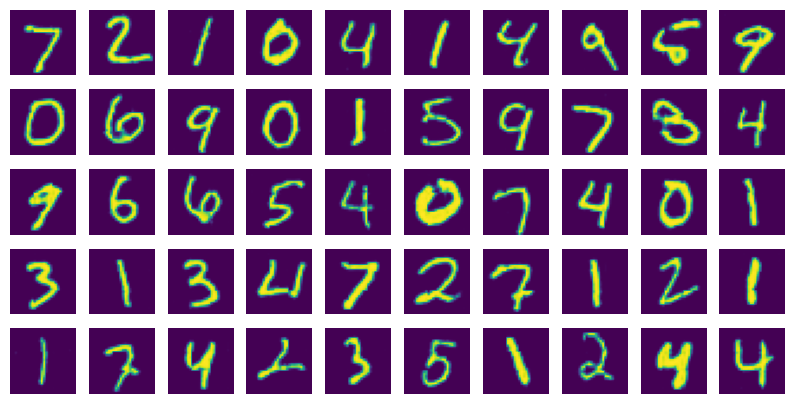

In [82]:
# decode한 이미지
plt.figure(figsize=(10,5))
for i in range(50) :
  plt.subplot(5,10,i+1)
  plt.imshow(decoded[i].cpu().permute(1, 2, 0))
  plt.axis('off')

plt.show()

확인 결과 노이즈가 제거된 이미지를 확인 할 수 있습니다.

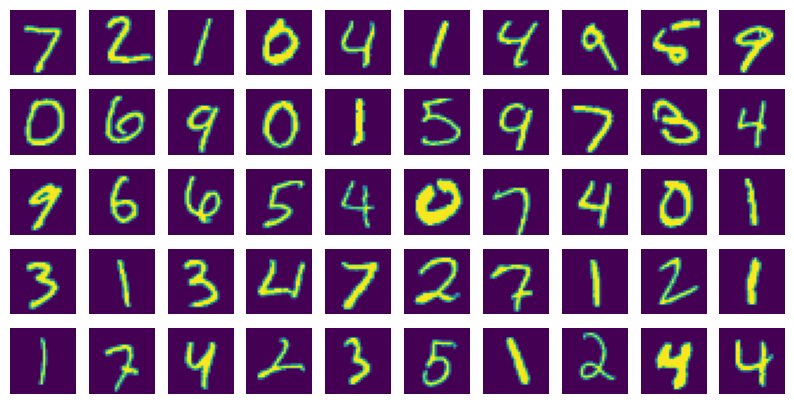

In [83]:
# 원본
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
for data, _ in test_loader:
    for i, dt in enumerate(data[:50]):
        plt.subplot(5, 10,i+1)
        plt.imshow(data[i].permute(1, 2, 0))
        plt.axis('off')
    break

plt.show()